In [ ]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install seaborn
%pip install scikit-learn

In [ ]:
import kagglehub
import pandas as pd
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
from collections import Counter
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, AdamW
from torch.nn import CrossEntropyLoss
from sklearn.metrics import classification_report, confusion_matrix
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
warnings.filterwarnings("ignore")

# Download latest version
path = kagglehub.dataset_download("charunisa/chatgpt-sentiment-analysis")
file_path = os.path.join(path, "file.csv")

df = pd.read_csv(file_path)

print(f"Numero di righe nel dataset: {df.shape[0]}")

df.head()

Numero di righe nel dataset: 219294


,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [2]:
df_cleaned = df.sample(n=30000, random_state=42)

# Eliminare colonne inutili
df_cleaned = df_cleaned.drop(columns=['Unnamed: 0'])

# Rimuovere duplicati
df_cleaned = df_cleaned.drop_duplicates()

# Verificare e gestire dati mancanti
df_cleaned = df_cleaned.dropna().reset_index(drop=True)  # Rimuove righe con valori NaN

print(f"Numero di righe nel dataset dopo la pulizia: {df_cleaned.shape[0]}")

df_cleaned.head()

Numero di righe nel dataset dopo la pulizia: 29906


,tweets,labels
0,ChatGPT is incredible.,bad
1,"RT ilovefreesw ""How to use Voice Commands to T...",bad
2,I asked ChatGPT a question about woodworking f...,bad
3,Me to Google after I discovered chatGPT😂 https...,bad
4,"When I started, I thought coding was the most ...",good


In [3]:
def clean_text(text):
    # Rimuove link, caratteri speciali e converte in minuscolo
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)  # Rimuove menzioni e hashtag
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)  # Mantiene solo lettere e numeri
    text = text.lower()  # Converte in minuscolo
    text = text.strip()  # Rimuove spazi extra
    return text

# Applicare la pulizia
df_cleaned['tweets'] = df_cleaned['tweets'].apply(clean_text)
df_cleaned['labels'] = df_cleaned['labels'].apply(clean_text)

df_cleaned.head()

,tweets,labels
0,chatgpt is incredible,bad
1,rt ilovefreesw how to use voice commands to ta...,bad
2,i asked chatgpt a question about woodworking f...,bad
3,me to google after i discovered chatgpt,bad
4,when i started i thought coding was the most i...,good


In [4]:
# Pulizia dei testi
cleaned_tweets = df_cleaned['tweets'].apply(clean_text)

# Contare le parole in ogni testo
word_counts = cleaned_tweets.apply(lambda x: len(str(x).split()))

# Calcolare il massimo numero di parole e il testo corrispondente
max_word_count = word_counts.max()

# Assicurarsi che l'indice massimo sia un intero e ottenere il testo corrispondente
max_word_index = word_counts.idxmax()
max_word_text = cleaned_tweets.loc[max_word_index]

# Calcolare la media delle parole
mean_word_count = word_counts.mean()

# Stampare i risultati
print(f"Massimo numero di parole: {max_word_count}")
print(f"Testo con più parole: {max_word_text}")
print(f"Media del numero di parole: {mean_word_count:.2f}")

Massimo numero di parole: 60
Testo con più parole: i think the best use for chatgpt is not to get answers it is to get the right terminology for what you want i was thinking of doing sth for weeks couldnt hack it then did it in couple days now d i also use it as an assistant to read code in python and tell me what it does
Media del numero di parole: 20.06


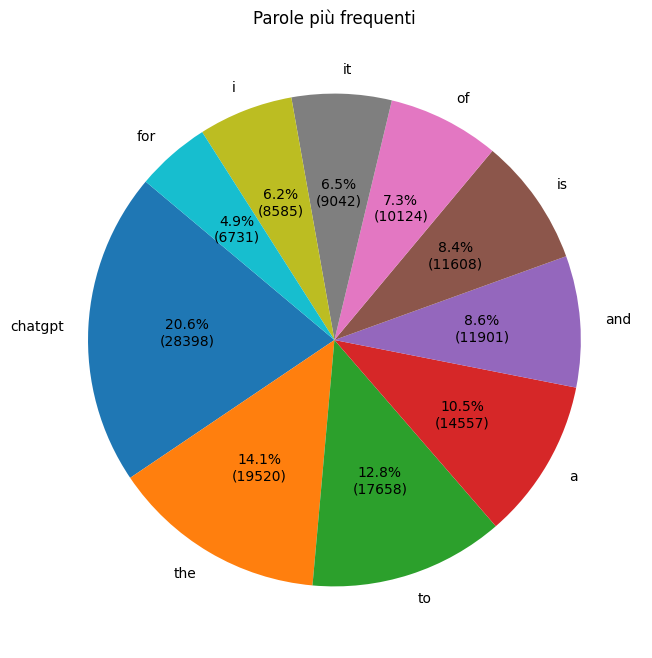

In [ ]:
# Unire tutti i testi in una singola stringa
all_words = ' '.join(cleaned_tweets).split()

# Contare la frequenza di ciascuna parola
word_freq = Counter(all_words)

# Ottenere le 10 parole più frequenti e le loro frequenze
most_common_words = word_freq.most_common(10)
words, frequencies = zip(*most_common_words)

# Funzione personalizzata per mostrare percentuale e conteggio
def make_autopct(frequencies):
    def autopct(pct):
        total = sum(frequencies)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return autopct

# Creare il diagramma a torta
plt.figure(figsize=(8, 8))
plt.pie(
    frequencies, 
    labels=words, 
    autopct=make_autopct(frequencies), 
    startangle=140
)
plt.title('Parole più frequenti')
plt.show()

labels
bad        14669
neutral     7629
good        7608
Name: count, dtype: int64


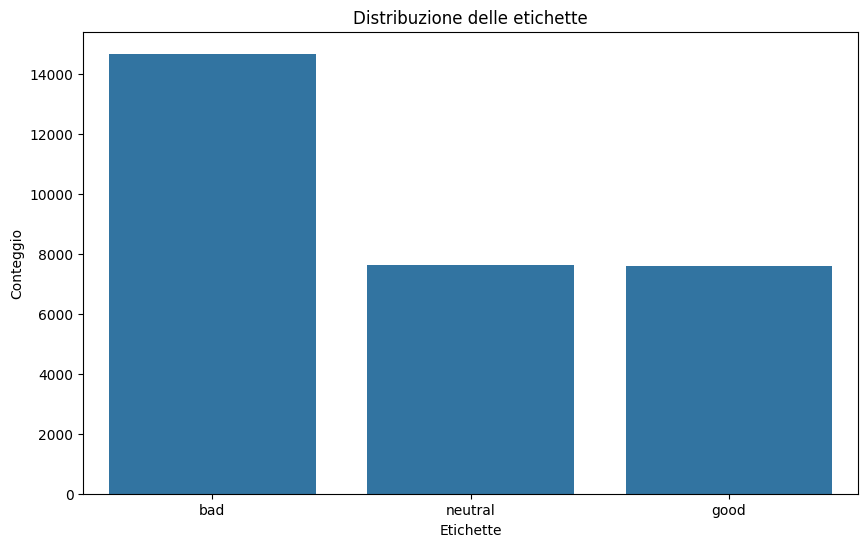

In [ ]:
# Controlla la distribuzione delle etichette
label_counts = df_cleaned['labels'].value_counts()

# Stampa i conteggi
print(label_counts)

# Visualizza la distribuzione
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribuzione delle etichette")
plt.xlabel("Etichette")
plt.ylabel("Conteggio")
plt.show()

labels
bad        7608
good       7608
neutral    7608
Name: count, dtype: int64


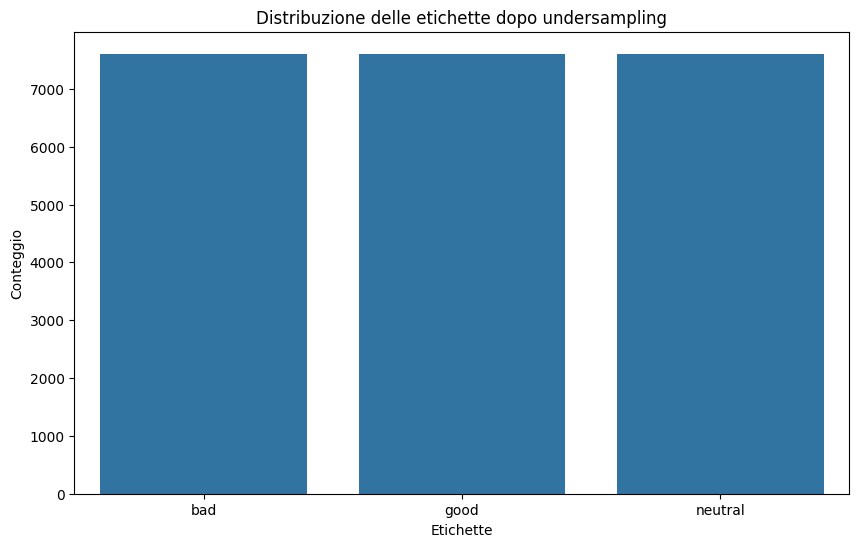

,tweets,labels
6433,its crazy how you can just say can you explain...,bad
7766,more evidence about the robustness of chatgpt nn,bad
28088,this very question is processed more than 30 s...,bad
8151,anyone using chatgpt are you having any logon...,bad
5040,stackoverflow to ban chatgpt generated answers...,bad


In [6]:
# Undersampling: trovare la dimensione della classe minoritaria
min_class_size = label_counts.min()

# Creare un nuovo dataset con undersampling
undersampled_data = df_cleaned.groupby('labels').sample(n=min_class_size, random_state=42)

# Verificare la nuova distribuzione delle etichette
undersampled_label_counts = undersampled_data['labels'].value_counts()

print(undersampled_label_counts)

# Visualizzare la nuova distribuzione delle etichette
plt.figure(figsize=(10, 6))
sns.barplot(x=undersampled_label_counts.index, y=undersampled_label_counts.values)
plt.title("Distribuzione delle etichette dopo undersampling")
plt.xlabel("Etichette")
plt.ylabel("Conteggio")
plt.show()

undersampled_data.head()

In [7]:
# Mappare le etichette a valori numerici
label_mapping = {'bad': 0, 'good': 1, 'neutral': 2}
undersampled_data['labels'] = undersampled_data['labels'].map(label_mapping)

print(undersampled_data['labels'].unique())

# Verifica
undersampled_data.head()

[0 1 2]


,tweets,labels
6433,its crazy how you can just say can you explain...,0
7766,more evidence about the robustness of chatgpt nn,0
28088,this very question is processed more than 30 s...,0
8151,anyone using chatgpt are you having any logon...,0
5040,stackoverflow to ban chatgpt generated answers...,0


In [ ]:
# Dividere il dataset in training e test set
X = undersampled_data['tweets']  # Feature
y = undersampled_data['labels']  # Target

# 80% per il training set e 20% per il test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verificare le dimensioni dei set
train_size = X_train.shape[0]
test_size = X_test.shape[0]

train_size, test_size

(18259, 4565)

# BERT

In [ ]:
# Inizializzare il tokenizer di BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizzare i dati del training e test set
X_train_tokens = tokenizer(list(X_train), padding=True, truncation=True, return_tensors="pt", max_length=128)
X_test_tokens = tokenizer(list(X_test), padding=True, truncation=True, return_tensors="pt", max_length=128)

# Controllare la struttura dei dati tokenizzati
train_token_structure = {key: value.shape for key, value in X_train_tokens.items()}
test_token_structure = {key: value.shape for key, value in X_test_tokens.items()}

train_token_structure, test_token_structure

({'input_ids': torch.Size([18259, 92]),
  'token_type_ids': torch.Size([18259, 92]),
  'attention_mask': torch.Size([18259, 92])},
 {'input_ids': torch.Size([4565, 112]),
  'token_type_ids': torch.Size([4565, 112]),
  'attention_mask': torch.Size([4565, 112])})

In [ ]:
# Preparare i tensori per l'input a BERT
# Utilizziamo `input_ids` e `attention_mask` dai dati tokenizzati
train_inputs = X_train_tokens['input_ids']
train_masks = X_train_tokens['attention_mask']
test_inputs = X_test_tokens['input_ids']
test_masks = X_test_tokens['attention_mask']

# Convertire i target in tensori PyTorch
train_labels = torch.tensor(y_train.values)
test_labels = torch.tensor(y_test.values)

# Controllare le dimensioni dei tensori preparati
tensor_shapes = {
    "train_inputs": train_inputs.shape,
    "train_masks": train_masks.shape,
    "train_labels": train_labels.shape,
    "test_inputs": test_inputs.shape,
    "test_masks": test_masks.shape,
    "test_labels": test_labels.shape,
}

tensor_shapes

{'train_inputs': torch.Size([18259, 92]),
 'train_masks': torch.Size([18259, 92]),
 'train_labels': torch.Size([18259]),
 'test_inputs': torch.Size([4565, 112]),
 'test_masks': torch.Size([4565, 112]),
 'test_labels': torch.Size([4565])}

In [11]:
# Convertire i target (`y_train` e `y_test`) in tensori PyTorch
train_labels = torch.tensor(y_train.values, dtype=torch.long)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Verificare le dimensioni dei tensori
train_labels_shape = train_labels.shape
test_labels_shape = test_labels.shape

train_labels_shape, test_labels_shape

(torch.Size([18259]), torch.Size([4565]))

In [ ]:
# Creare il dataset per il training e il test
train_dataset = TensorDataset(X_train_tokens['input_ids'], X_train_tokens['attention_mask'], train_labels)
test_dataset = TensorDataset(X_test_tokens['input_ids'], X_test_tokens['attention_mask'], test_labels)

# Creare i DataLoader per gestire i batch (8, 16, 32, 64)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verificare il numero di batch nei DataLoader
num_train_batches = len(train_dataloader)
num_test_batches = len(test_dataloader)

num_train_batches, num_test_batches

(571, 143)

In [ ]:
# Impostare il dispositivo (GPU o CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Caricare il modello pre-addestrato
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

# Definire l'ottimizzatore e la funzione di perdita
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = CrossEntropyLoss()

# Impostare il numero di epoche
epochs = 3

train_losses = []
train_accuracies = []

# Ciclo di addestramento
for epoch in range(epochs):
    print(f"Epoca {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    start_time = time.time()

    for step, batch in enumerate(train_dataloader):
        # Ottenere i dati del batch
        b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]

        # Azzerare i gradienti
        optimizer.zero_grad()

        # Passaggio in avanti
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        # Calcolare la perdita
        total_loss += loss.item()

        # Predizioni
        preds = torch.argmax(logits, dim=1)

        # Aggiornare il conteggio delle predizioni corrette
        correct_predictions += (preds == b_labels).sum().item()
        total_predictions += b_labels.size(0)

        # Passaggio indietro e aggiornamento dei pesi
        loss.backward()
        optimizer.step()

        # Monitoraggio del progresso
        if step % 10 == 0:
            elapsed_time = time.time() - start_time
            batches_left = len(train_dataloader) - (step + 1)
            estimated_time_left = (elapsed_time / (step + 1)) * batches_left
            print(
                f"  Batch {step + 1}/{len(train_dataloader)}, "
                f"Perdita batch: {loss.item():.4f}, "
                f"Tempo trascorso: {elapsed_time:.2f}s, "
                f"Tempo stimato rimanente: {estimated_time_left:.2f}s"
            )

    # Calcolare la perdita media e l'accuratezza per l'epoca
    avg_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions

    # Registrare le metriche
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    print(f"Perdita media: {avg_loss:.4f}")
    print(f"Accuratezza: {train_accuracy:.4f}")
    print(f"Tempo totale per epoca: {time.time() - start_time:.2f}s\n")

print("Addestramento completato.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoca 1/3
  Batch 1/571, Perdita batch: 1.0970, Tempo trascorso: 0.75s, Tempo stimato rimanente: 426.95s
  Batch 11/571, Perdita batch: 1.1199, Tempo trascorso: 5.67s, Tempo stimato rimanente: 288.85s
  Batch 21/571, Perdita batch: 1.0725, Tempo trascorso: 10.64s, Tempo stimato rimanente: 278.75s
  Batch 31/571, Perdita batch: 1.0324, Tempo trascorso: 15.62s, Tempo stimato rimanente: 272.14s
  Batch 41/571, Perdita batch: 1.0586, Tempo trascorso: 20.62s, Tempo stimato rimanente: 266.60s
  Batch 51/571, Perdita batch: 0.9956, Tempo trascorso: 25.64s, Tempo stimato rimanente: 261.43s
  Batch 61/571, Perdita batch: 0.9566, Tempo trascorso: 30.68s, Tempo stimato rimanente: 256.47s
  Batch 71/571, Perdita batch: 0.9024, Tempo trascorso: 35.73s, Tempo stimato rimanente: 251.59s
  Batch 81/571, Perdita batch: 1.0619, Tempo trascorso: 40.79s, Tempo stimato rimanente: 246.76s
  Batch 91/571, Perdita batch: 0.8664, Tempo trascorso: 45.86s, Tempo stimato rimanente: 241.91s
  Batch 101/571, Perdit

Perdita media (evaluation): 0.4078
Accuratezza media (evaluation): 0.8556

Classification Report per l'epoca:
              precision    recall  f1-score   support

         bad       0.94      0.87      0.90      1521
        good       0.83      0.93      0.88      1522
     neutral       0.80      0.77      0.79      1522

    accuracy                           0.86      4565
   macro avg       0.86      0.86      0.86      4565
weighted avg       0.86      0.86      0.86      4565



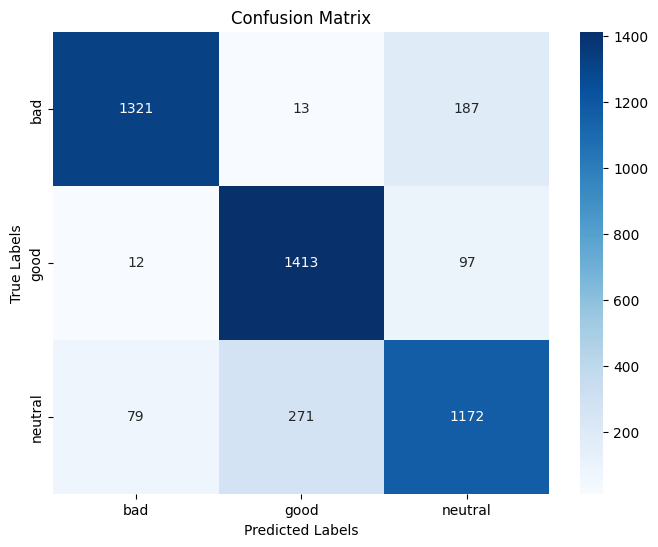

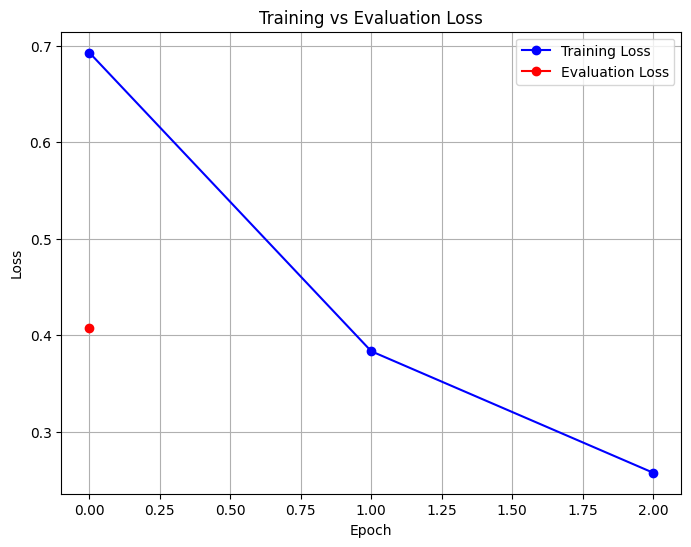

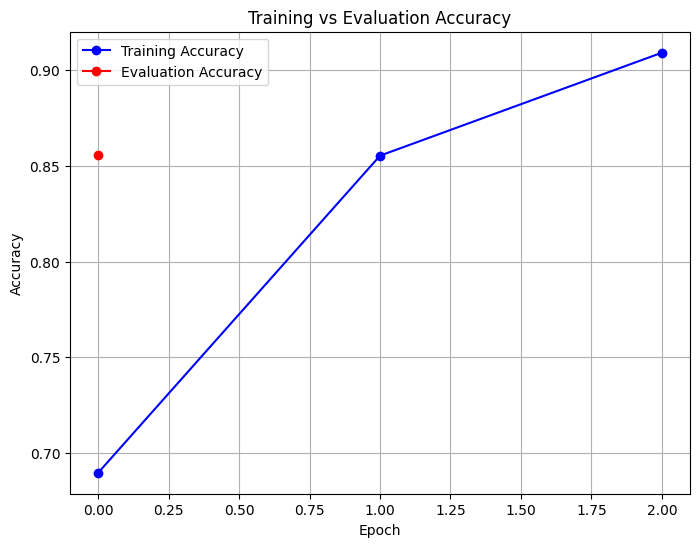

In [ ]:
# Liste per raccogliere le metriche per epoca
eval_losses_epoch = []
eval_accuracies_epoch = []

# Valutazione alla fine dell'epoca
model.eval()
all_preds = []
all_labels = []
total_loss = 0  # Somma delle perdite
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]

        # Ottenere le previsioni del modello
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        logits = outputs.logits
        loss = outputs.loss

        # Calcolare la perdita
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = b_labels.cpu().numpy()

        # Calcolare il numero di predizioni corrette
        correct_predictions += (preds == labels).sum()
        total_predictions += len(labels)

        all_preds.extend(preds)
        all_labels.extend(labels)

# Calcolare le metriche medie per epoca
avg_eval_loss = total_loss / len(test_dataloader)
avg_eval_accuracy = correct_predictions / total_predictions

# Salvare i valori per i grafici
eval_losses_epoch.append(avg_eval_loss)
eval_accuracies_epoch.append(avg_eval_accuracy)

print(f"Perdita media (evaluation): {avg_eval_loss:.4f}")
print(f"Accuratezza media (evaluation): {avg_eval_accuracy:.4f}")

# Calcolare il classification report
print("\nClassification Report per l'epoca:")
print(classification_report(all_labels, all_preds, target_names=['bad', 'good', 'neutral']))

# Calcolare la matrice di confusione
conf_matrix = confusion_matrix(all_labels, all_preds)

# Visualizzare la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['bad', 'good', 'neutral'], yticklabels=['bad', 'good', 'neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Grafico Loss: training vs evaluation
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss', marker='o', color='blue')
plt.plot(eval_losses_epoch, label='Evaluation Loss', marker='o', color='red')
plt.title('Training vs Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Grafico Accuracy: training vs evaluation
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Accuracy', marker='o', color='blue')
plt.plot(eval_accuracies_epoch, label='Evaluation Accuracy', marker='o', color='red')
plt.title('Training vs Evaluation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# RoBERTa

In [ ]:
# Inizializzare il tokenizer di RoBERTa
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenizzare i dati del training e test set
X_train_tokens = tokenizer(list(X_train), padding=True, truncation=True, return_tensors="pt", max_length=128)
X_test_tokens = tokenizer(list(X_test), padding=True, truncation=True, return_tensors="pt", max_length=128)

# Controllare la struttura dei dati tokenizzati
train_token_structure = {key: value.shape for key, value in X_train_tokens.items()}
test_token_structure = {key: value.shape for key, value in X_test_tokens.items()}

train_token_structure, test_token_structure

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

({'input_ids': torch.Size([18259, 106]),
  'attention_mask': torch.Size([18259, 106])},
 {'input_ids': torch.Size([4565, 103]),
  'attention_mask': torch.Size([4565, 103])})

In [ ]:
# Preparare i tensori per l'input a RoBERTa
# Utilizziamo `input_ids` e `attention_mask` dai dati tokenizzati
train_inputs = X_train_tokens['input_ids']
train_masks = X_train_tokens['attention_mask']
test_inputs = X_test_tokens['input_ids']
test_masks = X_test_tokens['attention_mask']

# Convertire i target in tensori PyTorch
train_labels = torch.tensor(y_train.values)
test_labels = torch.tensor(y_test.values)

# Controllare le dimensioni dei tensori preparati
tensor_shapes = {
    "train_inputs": train_inputs.shape,
    "train_masks": train_masks.shape,
    "train_labels": train_labels.shape,
    "test_inputs": test_inputs.shape,
    "test_masks": test_masks.shape,
    "test_labels": test_labels.shape,
}

tensor_shapes

{'train_inputs': torch.Size([18259, 106]),
 'train_masks': torch.Size([18259, 106]),
 'train_labels': torch.Size([18259]),
 'test_inputs': torch.Size([4565, 103]),
 'test_masks': torch.Size([4565, 103]),
 'test_labels': torch.Size([4565])}

In [25]:
# Convertire i target (`y_train` e `y_test`) in tensori PyTorch per RoBERTa
train_labels = torch.tensor(y_train.values, dtype=torch.long)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Verificare le dimensioni dei tensori
train_labels_shape = train_labels.shape
test_labels_shape = test_labels.shape

train_labels_shape, test_labels_shape

(torch.Size([18259]), torch.Size([4565]))

In [ ]:
# Creare il dataset per il training e il test per RoBERTa
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

# Creare i DataLoader per gestire i batch (ad esempio, 32)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verificare il numero di batch nei DataLoader
num_train_batches = len(train_dataloader)
num_test_batches = len(test_dataloader)

num_train_batches, num_test_batches

(571, 143)

In [ ]:
# Impostare il dispositivo (GPU o CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Caricare il modello pre-addestrato
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)
model.to(device)

# Definire l'ottimizzatore e la funzione di perdita
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = CrossEntropyLoss()

# Impostare il numero di epoche
epochs = 3

train_losses = []
train_accuracies = []

# Ciclo di addestramento
for epoch in range(epochs):
    print(f"Epoca {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    start_time = time.time()

    for step, batch in enumerate(train_dataloader):
        # Ottenere i dati del batch
        b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]

        # Azzerare i gradienti
        optimizer.zero_grad()

        # Passaggio in avanti
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        # Calcolare la perdita
        total_loss += loss.item()

        # Predizioni
        preds = torch.argmax(logits, dim=1)

        # Aggiornare il conteggio delle predizioni corrette
        correct_predictions += (preds == b_labels).sum().item()
        total_predictions += b_labels.size(0)

        # Passaggio indietro e aggiornamento dei pesi
        loss.backward()
        optimizer.step()

        # Monitoraggio del progresso
        if step % 10 == 0:
            elapsed_time = time.time() - start_time
            batches_left = len(train_dataloader) - (step + 1)
            estimated_time_left = (elapsed_time / (step + 1)) * batches_left
            print(
                f"  Batch {step + 1}/{len(train_dataloader)}, "
                f"Perdita batch: {loss.item():.4f}, "
                f"Tempo trascorso: {elapsed_time:.2f}s, "
                f"Tempo stimato rimanente: {estimated_time_left:.2f}s"
            )

    # Calcolare la perdita media e l'accuratezza per l'epoca
    avg_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions

    # Registrare le metriche
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    print(f"Perdita media: {avg_loss:.4f}")
    print(f"Accuratezza: {train_accuracy:.4f}")
    print(f"Tempo totale per epoca: {time.time() - start_time:.2f}s\n")

print("Addestramento completato.")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoca 1/3
  Batch 1/571, Perdita batch: 1.0851, Tempo trascorso: 0.67s, Tempo stimato rimanente: 381.34s
  Batch 11/571, Perdita batch: 1.1120, Tempo trascorso: 6.57s, Tempo stimato rimanente: 334.71s
  Batch 21/571, Perdita batch: 1.1103, Tempo trascorso: 12.62s, Tempo stimato rimanente: 330.56s
  Batch 31/571, Perdita batch: 1.0276, Tempo trascorso: 18.70s, Tempo stimato rimanente: 325.70s
  Batch 41/571, Perdita batch: 1.0789, Tempo trascorso: 24.70s, Tempo stimato rimanente: 319.30s
  Batch 51/571, Perdita batch: 1.0296, Tempo trascorso: 30.58s, Tempo stimato rimanente: 311.80s
  Batch 61/571, Perdita batch: 0.8989, Tempo trascorso: 36.39s, Tempo stimato rimanente: 304.28s
  Batch 71/571, Perdita batch: 0.9644, Tempo trascorso: 42.14s, Tempo stimato rimanente: 296.76s
  Batch 81/571, Perdita batch: 0.9544, Tempo trascorso: 47.83s, Tempo stimato rimanente: 289.36s
  Batch 91/571, Perdita batch: 0.8375, Tempo trascorso: 53.49s, Tempo stimato rimanente: 282.15s
  Batch 101/571, Perdit

Perdita media (evaluation): 0.4172
Accuratezza media (evaluation): 0.8342

Classification Report per l'epoca:
              precision    recall  f1-score   support

         bad       0.86      0.91      0.88      1521
        good       0.84      0.89      0.86      1522
     neutral       0.80      0.70      0.75      1522

    accuracy                           0.83      4565
   macro avg       0.83      0.83      0.83      4565
weighted avg       0.83      0.83      0.83      4565



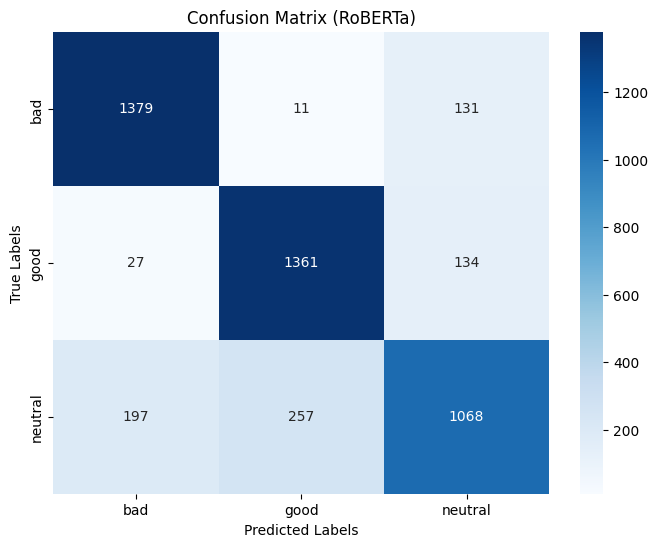

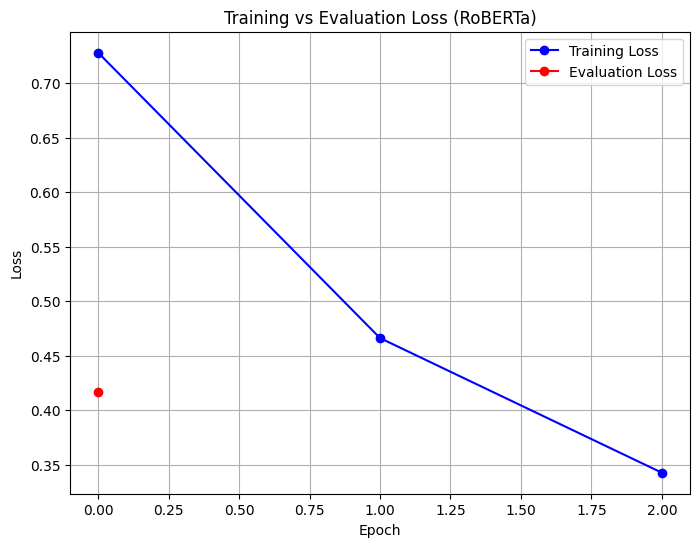

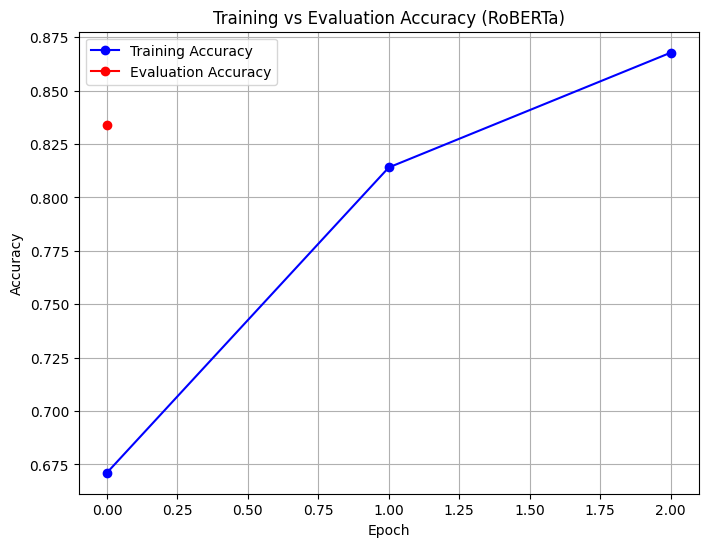

In [ ]:
# Liste per raccogliere le metriche per epoca
eval_losses_epoch = []
eval_accuracies_epoch = []

# Valutazione alla fine dell'epoca per RoBERTa
model.eval()
all_preds = []
all_labels = []
total_loss = 0  # Somma delle perdite
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]

        # Ottenere le previsioni del modello
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        logits = outputs.logits
        loss = outputs.loss

        # Calcolare la perdita
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = b_labels.cpu().numpy()

        # Calcolare il numero di predizioni corrette
        correct_predictions += (preds == labels).sum()
        total_predictions += len(labels)

        all_preds.extend(preds)
        all_labels.extend(labels)

# Calcolare le metriche medie per epoca
avg_eval_loss = total_loss / len(test_dataloader)
avg_eval_accuracy = correct_predictions / total_predictions

# Salvare i valori per i grafici
eval_losses_epoch.append(avg_eval_loss)
eval_accuracies_epoch.append(avg_eval_accuracy)

print(f"Perdita media (evaluation): {avg_eval_loss:.4f}")
print(f"Accuratezza media (evaluation): {avg_eval_accuracy:.4f}")

# Calcolare il classification report
print("\nClassification Report per l'epoca:")
print(classification_report(all_labels, all_preds, target_names=['bad', 'good', 'neutral']))

# Calcolare la matrice di confusione
conf_matrix = confusion_matrix(all_labels, all_preds)

# Visualizzare la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['bad', 'good', 'neutral'], yticklabels=['bad', 'good', 'neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (RoBERTa)')
plt.show()

# Grafico Loss: training vs evaluation
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss', marker='o', color='blue')
plt.plot(eval_losses_epoch, label='Evaluation Loss', marker='o', color='red')
plt.title('Training vs Evaluation Loss (RoBERTa)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Grafico Accuracy: training vs evaluation
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Accuracy', marker='o', color='blue')
plt.plot(eval_accuracies_epoch, label='Evaluation Accuracy', marker='o', color='red')
plt.title('Training vs Evaluation Accuracy (RoBERTa)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# DistilBERT

In [ ]:
# Inizializzare il tokenizer di DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenizzare i dati del training e test set
X_train_tokens = tokenizer(list(X_train), padding=True, truncation=True, return_tensors="pt", max_length=128)
X_test_tokens = tokenizer(list(X_test), padding=True, truncation=True, return_tensors="pt", max_length=128)

# Controllare la struttura dei dati tokenizzati
train_token_structure = {key: value.shape for key, value in X_train_tokens.items()}
test_token_structure = {key: value.shape for key, value in X_test_tokens.items()}

train_token_structure, test_token_structure

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

({'input_ids': torch.Size([18259, 92]),
  'attention_mask': torch.Size([18259, 92])},
 {'input_ids': torch.Size([4565, 112]),
  'attention_mask': torch.Size([4565, 112])})

In [ ]:
# Preparare i tensori per l'input a DistilBERT
# Utilizziamo `input_ids` e `attention_mask` dai dati tokenizzati
train_inputs = X_train_tokens['input_ids']
train_masks = X_train_tokens['attention_mask']
test_inputs = X_test_tokens['input_ids']
test_masks = X_test_tokens['attention_mask']

# Convertire i target in tensori PyTorch
train_labels = torch.tensor(y_train.values, dtype=torch.long)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Controllare le dimensioni dei tensori preparati
tensor_shapes = {
    "train_inputs": train_inputs.shape,
    "train_masks": train_masks.shape,
    "train_labels": train_labels.shape,
    "test_inputs": test_inputs.shape,
    "test_masks": test_masks.shape,
    "test_labels": test_labels.shape,
}

tensor_shapes

{'train_inputs': torch.Size([18259, 92]),
 'train_masks': torch.Size([18259, 92]),
 'train_labels': torch.Size([18259]),
 'test_inputs': torch.Size([4565, 112]),
 'test_masks': torch.Size([4565, 112]),
 'test_labels': torch.Size([4565])}

In [39]:
# Convertire i target (`y_train` e `y_test`) in tensori PyTorch per DistilBERT
train_labels = torch.tensor(y_train.values, dtype=torch.long)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Verificare le dimensioni dei tensori
train_labels_shape = train_labels.shape
test_labels_shape = test_labels.shape

train_labels_shape, test_labels_shape

(torch.Size([18259]), torch.Size([4565]))

In [ ]:
# Creare il dataset per il training e il test per DistilBERT
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

# Creare i DataLoader per gestire i batch (ad esempio, 32)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verificare il numero di batch nei DataLoader
num_train_batches = len(train_dataloader)
num_test_batches = len(test_dataloader)

num_train_batches, num_test_batches

(571, 143)

In [ ]:
# Impostare il dispositivo (GPU o CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Caricare il modello pre-addestrato
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
model.to(device)

# Definire l'ottimizzatore e la funzione di perdita
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = CrossEntropyLoss()

# Impostare il numero di epoche
epochs = 3

train_losses = []
train_accuracies = []

# Ciclo di addestramento
for epoch in range(epochs):
    print(f"Epoca {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    start_time = time.time()

    for step, batch in enumerate(train_dataloader):
        # Ottenere i dati del batch
        b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]

        # Azzerare i gradienti
        optimizer.zero_grad()

        # Passaggio in avanti
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        # Calcolare la perdita
        total_loss += loss.item()

        # Predizioni
        preds = torch.argmax(logits, dim=1)

        # Aggiornare il conteggio delle predizioni corrette
        correct_predictions += (preds == b_labels).sum().item()
        total_predictions += b_labels.size(0)

        # Passaggio indietro e aggiornamento dei pesi
        loss.backward()
        optimizer.step()

        # Monitoraggio del progresso
        if step % 10 == 0:
            elapsed_time = time.time() - start_time
            batches_left = len(train_dataloader) - (step + 1)
            estimated_time_left = (elapsed_time / (step + 1)) * batches_left
            print(
                f"  Batch {step + 1}/{len(train_dataloader)}, "
                f"Perdita batch: {loss.item():.4f}, "
                f"Tempo trascorso: {elapsed_time:.2f}s, "
                f"Tempo stimato rimanente: {estimated_time_left:.2f}s"
            )

    # Calcolare la perdita media e l'accuratezza per l'epoca
    avg_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions

    # Registrare le metriche
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    print(f"Perdita media: {avg_loss:.4f}")
    print(f"Accuratezza: {train_accuracy:.4f}")
    print(f"Tempo totale per epoca: {time.time() - start_time:.2f}s\n")

print("Addestramento completato.")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoca 1/3
  Batch 1/571, Perdita batch: 1.0877, Tempo trascorso: 0.25s, Tempo stimato rimanente: 140.44s
  Batch 11/571, Perdita batch: 1.1010, Tempo trascorso: 2.62s, Tempo stimato rimanente: 133.15s
  Batch 21/571, Perdita batch: 1.0952, Tempo trascorso: 5.13s, Tempo stimato rimanente: 134.46s
  Batch 31/571, Perdita batch: 1.0621, Tempo trascorso: 7.65s, Tempo stimato rimanente: 133.34s
  Batch 41/571, Perdita batch: 1.0183, Tempo trascorso: 10.21s, Tempo stimato rimanente: 132.02s
  Batch 51/571, Perdita batch: 0.9727, Tempo trascorso: 12.79s, Tempo stimato rimanente: 130.42s
  Batch 61/571, Perdita batch: 0.8970, Tempo trascorso: 15.37s, Tempo stimato rimanente: 128.54s
  Batch 71/571, Perdita batch: 0.9911, Tempo trascorso: 17.97s, Tempo stimato rimanente: 126.52s
  Batch 81/571, Perdita batch: 0.8346, Tempo trascorso: 20.53s, Tempo stimato rimanente: 124.19s
  Batch 91/571, Perdita batch: 0.9805, Tempo trascorso: 23.06s, Tempo stimato rimanente: 121.63s
  Batch 101/571, Perdita 

Perdita media (evaluation): 0.4019
Accuratezza media (evaluation): 0.8475

Classification Report per l'epoca:
              precision    recall  f1-score   support

         bad       0.93      0.85      0.89      1521
        good       0.88      0.86      0.87      1522
     neutral       0.75      0.83      0.79      1522

    accuracy                           0.85      4565
   macro avg       0.85      0.85      0.85      4565
weighted avg       0.85      0.85      0.85      4565



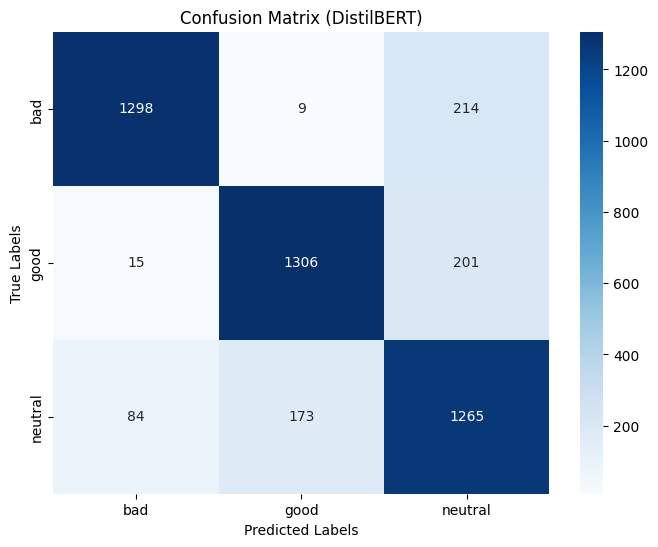

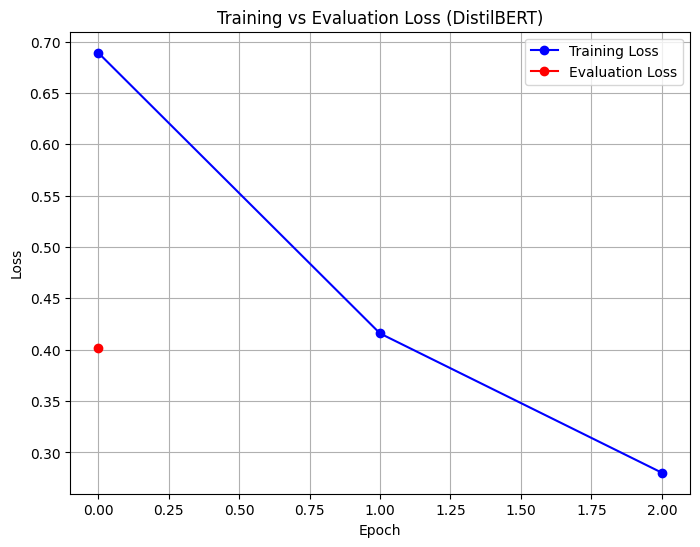

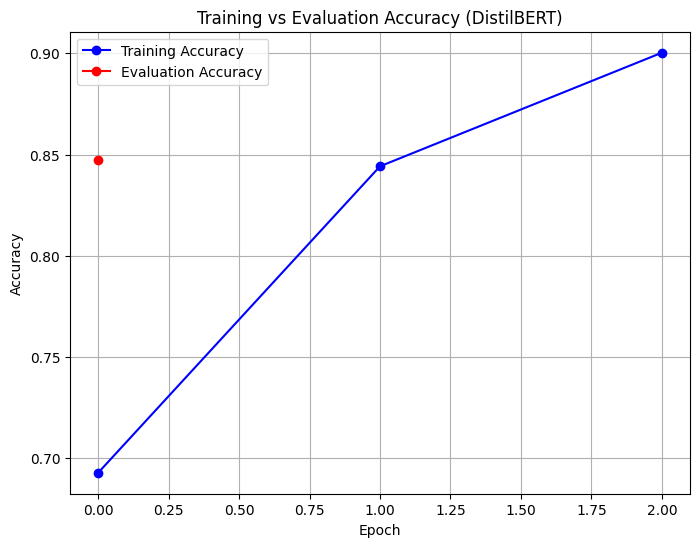

In [ ]:
# Liste per raccogliere le metriche per epoca
eval_losses_epoch = []
eval_accuracies_epoch = []

# Valutazione alla fine dell'epoca per DistilBERT
model.eval()
all_preds = []
all_labels = []
total_loss = 0  # Somma delle perdite
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]

        # Ottenere le previsioni del modello
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        logits = outputs.logits
        loss = outputs.loss

        # Calcolare la perdita
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = b_labels.cpu().numpy()

        # Calcolare il numero di predizioni corrette
        correct_predictions += (preds == labels).sum()
        total_predictions += len(labels)

        all_preds.extend(preds)
        all_labels.extend(labels)

# Calcolare le metriche medie per epoca
avg_eval_loss = total_loss / len(test_dataloader)
avg_eval_accuracy = correct_predictions / total_predictions

# Salvare i valori per i grafici
eval_losses_epoch.append(avg_eval_loss)
eval_accuracies_epoch.append(avg_eval_accuracy)

print(f"Perdita media (evaluation): {avg_eval_loss:.4f}")
print(f"Accuratezza media (evaluation): {avg_eval_accuracy:.4f}")

# Calcolare il classification report
print("\nClassification Report per l'epoca:")
print(classification_report(all_labels, all_preds, target_names=['bad', 'good', 'neutral']))

# Calcolare la matrice di confusione
conf_matrix = confusion_matrix(all_labels, all_preds)

# Visualizzare la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['bad', 'good', 'neutral'], yticklabels=['bad', 'good', 'neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (DistilBERT)')
plt.show()

# Grafico Loss: training vs evaluation
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss', marker='o', color='blue')
plt.plot(eval_losses_epoch, label='Evaluation Loss', marker='o', color='red')
plt.title('Training vs Evaluation Loss (DistilBERT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Grafico Accuracy: training vs evaluation
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Accuracy', marker='o', color='blue')
plt.plot(eval_accuracies_epoch, label='Evaluation Accuracy', marker='o', color='red')
plt.title('Training vs Evaluation Accuracy (DistilBERT)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()